<a href="https://colab.research.google.com/github/Last-Vega/Klis_Workshop_MachineLearning/blob/master/TrainPokemonEggType.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
path = '/content/drive/MyDrive/Colab Notebooks/myproject/data/AllDataSet.zip'
with zipfile.ZipFile(path) as zf:
  zf.extractall()



In [3]:
import os
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import numpy as np

In [4]:
# 分類するクラス
classes = ['Field', 'Undiscovered', 'Bug', 'Amorphous', 'Dragon', 'Fairy', 'Mineral', 
           'Flying', 'Grass', 'Human-Like', 'Monster', 'Water']

nb_classes = len(classes)

img_width, img_height = 150, 150

# トレーニング用とバリデーション用の画像格納先
# train_data_dir = 'AllDataSet/train'
# validation_data_dir = 'AllDataSet/validation'

#colab用の格納先
train_data_dir = '/content/AllDataSet/train'
validation_data_dir = '/content/AllDataSet/validation'

nb_train_samples = 5225
nb_validation_samples = 4715

batch_size = 32
nb_epoch = 20

In [5]:
def vgg_model_maker():
    """ VGG16のモデルをFC層以外使用。FC層のみ作成して結合して用意する """

    # VGG16のロード。FC層は不要なので include_top=False
    input_tensor = Input(shape=(img_width, img_height, 3))
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

    # FC層の作成
    top_model = Sequential()
    top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(nb_classes, activation='softmax'))

    # VGG16とFC層を結合してモデルを作成
    model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

    return model

In [6]:
def image_generator():
    """ ディレクトリ内の画像を読み込んでトレーニングデータとバリデーションデータの作成 """
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        zoom_range=0.2,
        horizontal_flip=True)

    validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        color_mode='rgb',
        classes=classes,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True)

    validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        color_mode='rgb',
        classes=classes,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True)

    return (train_generator, validation_generator)

In [7]:
result_dir = 'results'
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

In [8]:
# モデル作成
vgg_model = vgg_model_maker()

# 最後のconv層の直前までの層をfreeze
for layer in vgg_model.layers[:15]:
    layer.trainable = False

# 多クラス分類を指定
vgg_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
                metrics=['accuracy'])

# 画像のジェネレータ生成
train_generator, validation_generator = image_generator()

# Fine-tuning

history = vgg_model.fit_generator(
    train_generator,
    steps_per_epoch=int(nb_train_samples/batch_size),
    epochs=nb_epoch,
    validation_data=validation_generator,
    validation_steps=int(nb_validation_samples/batch_size)
)

vgg_model.save_weights(os.path.join(result_dir, 'finetuning.h5'))

58892288/58889256 [==============================] - 2s 0us/step
Found 5225 images belonging to 12 classes.
Found 4715 images belonging to 12 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
163/163 [==============================] - ETA: 0s - loss: 2.4560 - accuracy: 0.1394

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


163/163 [==============================] - 80s 489ms/step - loss: 2.4560 - accuracy: 0.1394 - val_loss: 2.3475 - val_accuracy: 0.1756
Epoch 2/20
163/163 [==============================] - 80s 490ms/step - loss: 2.0852 - accuracy: 0.3048 - val_loss: 2.0446 - val_accuracy: 0.3163
Epoch 3/20
163/163 [==============================] - 80s 488ms/step - loss: 1.6031 - accuracy: 0.4814 - val_loss: 1.7665 - val_accuracy: 0.4116
Epoch 4/20
163/163 [==============================] - 79s 484ms/step - loss: 1.1286 - accuracy: 0.6461 - val_loss: 1.8439 - val_accuracy: 0.4250
Epoch 5/20
163/163 [==============================] - 79s 487ms/step - loss: 0.7572 - accuracy: 0.7660 - val_loss: 2.1499 - val_accuracy: 0.3771
Epoch 6/20
163/163 [==============================] - 79s 485ms/step - loss: 0.4920 - accuracy: 0.8467 - val_loss: 1.8394 - val_accuracy: 0.4609
Epoch 7/20
163/163 [==============================] - 81s 495ms/step - loss: 0.3623 - accuracy: 0.8866 - val_loss: 2.0104 - val_accuracy: 0.4

In [9]:
from google.colab import files
files.download( "/content/results/finetuning.h5" )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

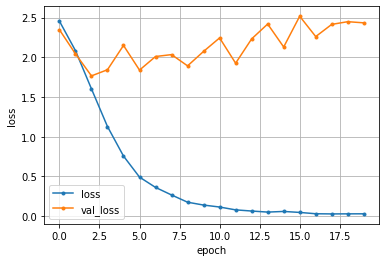

In [10]:
import matplotlib.pyplot as plt
loss     = history.history['loss']
val_loss = history.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

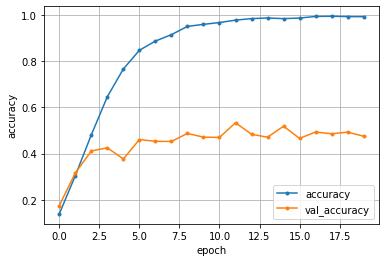

In [11]:
loss     = history.history['accuracy']
val_loss = history.history['val_accuracy']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='accuracy')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_accuracy')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()